In [1]:
#imports
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.naive_bayes import BernoulliNB
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/kristin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Naive Baysian Sentiment Prediction

This is an assignment for my thinkful data science course - "naive_bayes_sentiment_prediction"
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/naive_bayes_sentiment_prediction.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/naive_bayes_sentiment_prediction.ipynb) - with all the code exposed in an interactive notebook

I've chosen to use features that are all one-hot features, each indicating presence or absence of a particular lemma in the review sentence.  

I've chosen the lemmas by first finding those that most frequently occur in sentences (highest occurrence rate), and then selecting those that split sentiment best (highest split rate).  When this feature selection process is applied to the imdb dataset, those features work quite nicely to predict sentiment (error rate is 16%).

I've explored generalizability by applying subsets of the process to the amazon dataset.  I explored generalizability at 3 levels: same features and model; same features but new model; same feature selection process but new features and new model. The performance improves as the process is made more specific to the amazon dataset, with error rates of 32%, 20% and 13% respectively. 

With some additional work some re-usable elements could be developed from the elements built here: 

* the "lemmatization" of a sentence into a list of lemmas
* the "occurrence rate" calculation for lemmas in a corpus of word lists
* the "split rate" calculation for a one-hot predictor on a one-hot target variable

To further improve performance, these features could be evaluated: 

* presence of punctuation types
* prevalence of punctuation types
* length of sentence
* pronouns (removed as stop words in the process used here)
* prevalence of capitals


In [2]:
# Grab and process the raw data.

sent_raw = pd.read_csv("imdb_labelled.txt", delimiter= '\t', header=None)
sent_raw.columns = ['sentence', 'sentiment']

In [3]:
#check for nulls
def count_nulls(df):
    n = len(df)
    cols = df.columns
    num_null = [len(df[df[col].isnull()]) / n for col in df]
    return pd.DataFrame([cols, num_null]).transpose()

count_nulls(sent_raw)

,0,1
0,sentence,0
1,sentiment,0


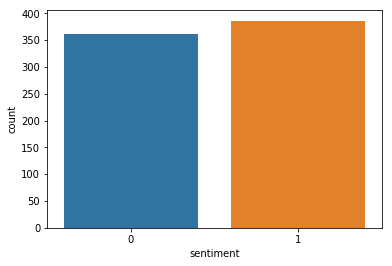

In [4]:
#peak at the distribution - binomial seems like the right choice :)
sns.countplot(sent_raw["sentiment"])

In [5]:
#all of the constants and functions used in this notebook

#some constants: 
lemmatizer = WordNetLemmatizer()
stops = stopwords.words("english")

def word_count(words, counts, exclusions):
    words

    for word in words:
        word = word.translate(str.maketrans('', '', string.punctuation))
        word = word.lower()
        
        if word not in exclusions:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1

    return (counts)

def lemmatize_sentence(sentence):
    lemma_list = []
    words = sentence.split()
    for word in words:
        word = word.translate(str.maketrans('', '', string.punctuation))
        word = word.lower()
        word = lemmatizer.lemmatize(word)
        lemma_list.append(word)
    return np.array(lemma_list)

def lemmatize_sentences(df):
    counts = dict()
    counts.clear()
    df["lemmas"] = "empty"

    for index, row in df.iterrows():
        lems = lemmatize_sentence(df.loc[index, "sentence"])
        df.at[index, "lemmas"] = lems
        counts = word_count(lems, counts, stops)
    return counts

def has_lemma(word_list, lemma): 
    return (lemma in word_list)

def split_rate(df, lemma_col, lemma, outcome):
    hot = [lemma in lemmas for lemmas in df[lemma_col]]
    n = sum(hot)
    positive = len(df[hot & df[outcome]]) / n
    negative = 1-positive
    return max(positive, negative)

def get_best_splitters(df, lemmas, lemma_col, outcome, cutoff):
    split_rates = pd.DataFrame([(lemma, split_rate(df, lemma_col, lemma, "sentiment")) for lemma in lemmas])
    split_rates.columns = ["lemma", "split_rate"]
    split_rates = split_rates[split_rates["split_rate"] > cutoff].sort_values(by="split_rate", ascending=False)
    return split_rates["lemma"].values

def kw_feature_creation(df, words): 
    for index, row in sent_raw.iterrows():
        for word in words: 
            df.loc[index, str(word)] = [(word in df.loc[index, "lemmas"])] 
            
def test_any_feature_present(df, cols):
    
    hot = 0
    not_hot = 0

    for index, row in df.iterrows():
        if df.loc[index, cols].values.any():
            hot += 1
        else: 
            not_hot += 1

    print("hit rate is ", hot / (hot + not_hot))
    
def train_and_predict(features, target):
    bnb = BernoulliNB()
    bnb.fit(features, target)
    return bnb.predict(features)

def evaluate_model(target, y_pred):
    print("error rate is ", (target != y_pred).sum() / data.shape[0])

In [6]:
#add a column of the lemmas in each sentence, and calculate the occurrence rate of each lemma
sorted_lemmas = sorted(lemmatize_sentences(sent_raw).items(),  key=lambda x: x[1], reverse = True)

In [7]:
#calculate how well each lemma splits sentiment and choose best splitters
top_lemmas = [x[0] for x in sorted_lemmas[:300]]  #most frequently occurring lemmas
keywords = get_best_splitters(sent_raw, top_lemmas, "lemmas", "sentiment", .5)   #best splitting lemmas
print(keywords)

['interesting' 'couldnt' 'awful' 'sucked' 'brilliant' 'cheap' 'poor'
 'ridiculous' 'money' 'hilarious' 'picture' 'wasted' 'terrific' 'annoying'
 'joy' 'worst' 'whatever' 'suck' 'pathetic' 'role' 'silent' 'wonderful'
 'waste' 'stupid' 'nothing' 'bad' 'played' 'loved' 'liked' 'im' 'action'
 'girl' 'place' 'word' 'hour' 'mess' 'give' 'family' 'cool' 'perfect'
 'disappointed' 'nice' 'rating' 'let' 'excellent' 'half' 'subtle' 'would'
 'lack' 'art' 'job' 'funny' 'old' 'john' 'terrible' 'beautiful' 'avoid'
 'worse' 'actually' 'level' 'memorable' 'crap' 'tom' 'guess' 'single'
 'fun' 'plot' 'lame' 'away' 'problem' 'didnt' 'cartoon' 'beyond' 'mostly'
 'fails' 'yet' 'started' 'wont' 'bit' 'performance' 'horrible' 'cost'
 'even' 'great' 'still' 'line' 'definitely' 'almost' 'white' 'cant' 'show'
 'much' 'little' 'kind' 'right' 'direction' 'cinematography' 'long' 'try'
 'said' 'truly' 'completely' 'hole' 'incredible' 'saw' 'enjoyed' 'love'
 'year' 'minute' 'short' 'play' 'script' 'think' 'comedy' 'p

In [8]:
#create features using the top splitting lemmas and add them to the dataframe
kw_feature_creation(sent_raw, keywords)

In [9]:
#test to see how many sentences have any of the features I've selected
test_any_feature_present(sent_raw, keywords)


hit rate is  0.9625668449197861


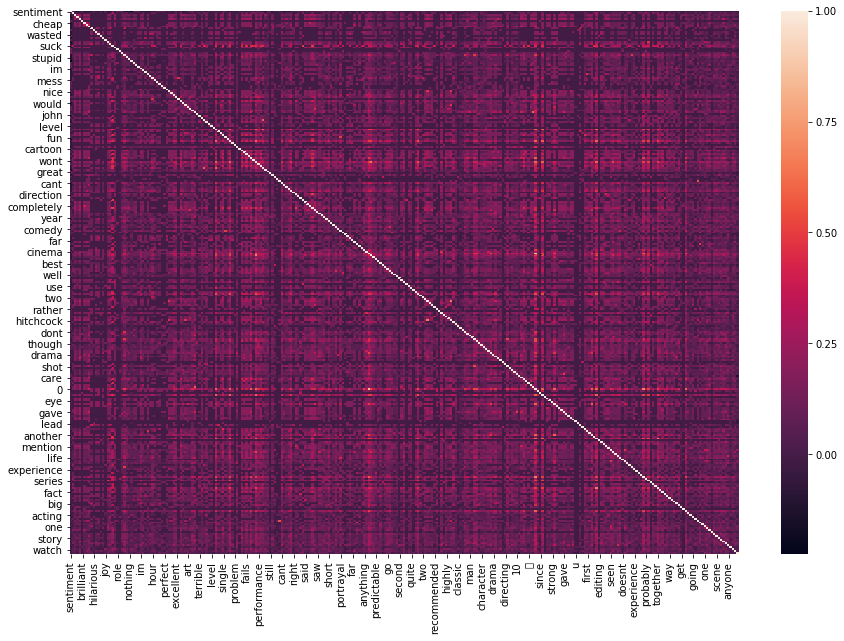

In [10]:
#test for correlation between feature pairs - looks pretty good (i.e. low correlation)
plt.figure(figsize=(15, 10))
sns.heatmap(sent_raw.corr())

In [11]:
#train and evaluate the model
data = sent_raw[keywords]
outcome = sent_raw['sentiment']
#predictions = train_and_predict(data, outcome)
bnb = BernoulliNB()
bnb.fit(data, outcome)
predictions = bnb.predict(data)
evaluate_model(outcome, predictions)


error rate is  0.16310160427807488


hit rate is  0.869


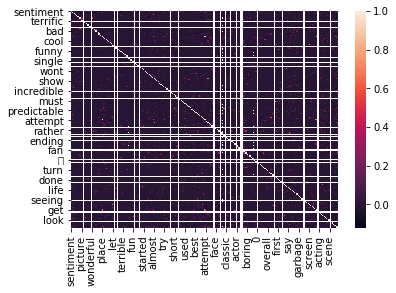

error rate is  0.318


In [12]:
#test the prediction process on a new dataset - the amazon reviews - using the same features and trained model

#read the data
sent_raw = pd.read_csv("amazon_cells_labelled.txt", delimiter= '\t', header=None)
sent_raw.columns = ['sentence', 'sentiment']

#lemmatize the sentences
sorted_lemmas = sorted(lemmatize_sentences(sent_raw).items(),  key=lambda x: x[1], reverse = True)

#create features
kw_feature_creation(sent_raw, keywords)

#test to see how many sentences have any of the features I've selected
test_any_feature_present(sent_raw, keywords)

#test for correlation between feature pairs
sns.heatmap(sent_raw.corr())
plt.show()

#evaluate the model
data = sent_raw[keywords]
outcome = sent_raw['sentiment']
#bnb = BernoulliNB()       #removing so that existing model is used
#bnb.fit(data, outcome)    #removing so that existing model is used
predictions = bnb.predict(data)
evaluate_model(outcome, predictions)

hit rate is  0.869


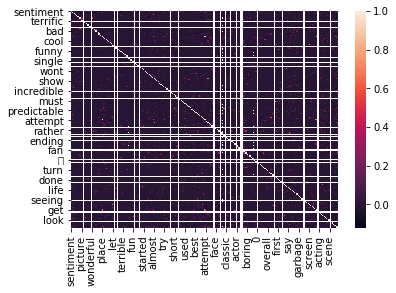

error rate is  0.201


In [13]:
#use the same features but a new model trained on the new data

#read the data
sent_raw = pd.read_csv("amazon_cells_labelled.txt", delimiter= '\t', header=None)
sent_raw.columns = ['sentence', 'sentiment']

#lemmatize the sentences
sorted_lemmas = sorted(lemmatize_sentences(sent_raw).items(),  key=lambda x: x[1], reverse = True)

#create features
kw_feature_creation(sent_raw, keywords)

#test to see how many sentences have any of the features I've selected
test_any_feature_present(sent_raw, keywords)

#test for correlation between feature pairs
sns.heatmap(sent_raw.corr())
plt.show()

#train & evaluate the model
data = sent_raw[keywords]
outcome = sent_raw['sentiment']
bnb = BernoulliNB()
bnb.fit(data, outcome)
predictions = bnb.predict(data)
evaluate_model(outcome, predictions)


['horrible' 'suck' 'none' 'order' 'nice' 'love' 'break' 'definitely'
 'family' 'crap' 'pleased' 'comfortably' 'disappointing' 'seller' 'waste'
 'weak' 'worst' 'charm' 'bad' 'awesome' 'range' 'anything' 'poor' 'old'
 'buying' 'return' 'sturdy' 'priced' 'unreliable' 'free' 'fast' 'later'
 'leather' 'support' 'keyboard' 'seems' 'didnt' 'hate' 'useless' 'junk'
 'pc' 'broke' 'drain' 'perfectly' 'unit' 'difficult' 'value' 'mistake'
 'terrible' 'disappointed' 'instruction' 'easily' 'disappointment'
 'excellent' 'money' 'great' 'price' 'fine' 'best' 'customer' 'pretty'
 'highly' 'first' 'doesnt' 'however' 'back' 'jabra' 'without' 'happy'
 'company' 'completely' 'talk' 'stay' 'went' 'cant' 'hand' 'piece' 'hear'
 'want' 'anyone' 'come' 'put' 'drop' 'within' '5' 'clear' 'dont' 'easy'
 'good' 'working' 'well' 'could' 'comfortable' 'conversation' 'kind'
 'tool' 'clarity' 'samsung' 'place' 'cannot' 'player' 'button' 'week'
 'lot' 'quickly' '3' 'plastic' 'especially' 'shipping' 'others' 'job'
 'start

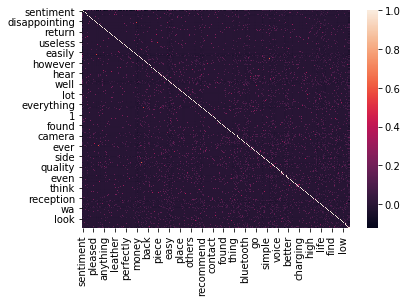

error rate is  0.133


In [14]:
#use new features and a new model, but follow the same general process

#read the data
sent_raw = pd.read_csv("amazon_cells_labelled.txt", delimiter= '\t', header=None)
sent_raw.columns = ['sentence', 'sentiment']

#lemmatize the sentences
sorted_lemmas = sorted(lemmatize_sentences(sent_raw).items(),  key=lambda x: x[1], reverse = True)

#ADDING: develop a new keyword (lemma) list from the amazon dataset
top_lemmas = [x[0] for x in sorted_lemmas[:300]]  #most frequently occurring lemmas
keywords = get_best_splitters(sent_raw, top_lemmas, "lemmas", "sentiment", .5)   #best splitting lemmas
print(keywords)

#create features
kw_feature_creation(sent_raw, keywords)

#test to see how many sentences have any of the features I've selected
test_any_feature_present(sent_raw, keywords)

#test for correlation between feature pairs
sns.heatmap(sent_raw.corr())
plt.show()

#train & evaluate the model
data = sent_raw[keywords]
outcome = sent_raw['sentiment']
bnb = BernoulliNB()
bnb.fit(data, outcome)
predictions = bnb.predict(data)
evaluate_model(outcome, predictions)